<a href="https://colab.research.google.com/github/AnnaScibska/Deep_learning_flowers_data_set/blob/master/almost_done.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hello,

This is my final model for dataset: [flower recognition - kaggle](https://www.kaggle.com/alxmamaev/flowers-recognition)

Max accuracy I was able to achieve on the train data is 87%. 

In the dataset there's plenty of pictures that are bad example: 
- person holding a tiny flower, 
- a bug sitting on the flower, where the flower is only a foggy background, 
- and the hardest of them all: a field of flowers - you have to take a close look to recognize which flower is on the particular picture,
- etc. 

So for the given dataset I think the result is not that bad :)

I was struggling with the overfitting - I had huge drop of accuracy at the beginning when evaluating model after finishing training with 99% accuracy (hence validation during the training and training ceiling).

I gain some accuracy by adding additional convolution and pooling layers.

It help a lot to increase the dataset size by adding pictures flipped vertically.

The best solution for overfitting was **ImageDataGenerator** that boosted the accuracy to the descent level.

I experimented with number of neurons in a layer, batch size, learning rate etc. And this is the best I could come up with.

Although it was fun :) I had to stop at one point.

## Imports

In [0]:
import tensorflow as tf
import numpy as np
import cv2
import math
import os
import pathlib
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

## Upload data from kaggle

In [2]:
file = open('/content/kaggle.json', 'w')
file.write('{\"username\":\"freeanke\",\"key\":\"92b509cecb01045514b22adb0910675c\"}')
file.close()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d alxmamaev/flowers-recognition
!unzip flowers-recognition

Streaming output truncated to the last 5000 lines.
  inflating: flowers/flowers/rose/11102341464_508d558dfc_n.jpg  
  inflating: flowers/flowers/rose/11233672494_d8bf0a3dbf_n.jpg  
  inflating: flowers/flowers/rose/11694025703_9a906fedc1_n.jpg  
  inflating: flowers/flowers/rose/118974357_0faa23cce9_n.jpg  
  inflating: flowers/flowers/rose/11944957684_2cc806276e.jpg  
  inflating: flowers/flowers/rose/12165480946_c4a3fe182d_n.jpg  
  inflating: flowers/flowers/rose/12202373204_34fb07205b.jpg  
  inflating: flowers/flowers/rose/12238827553_cf427bfd51_n.jpg  
  inflating: flowers/flowers/rose/12240165555_98625b1e88_n.jpg  
  inflating: flowers/flowers/rose/12240303_80d87f77a3_n.jpg  
  inflating: flowers/flowers/rose/12240577184_b0de0e53ea_n.jpg  
  inflating: flowers/flowers/rose/12243068283_ee4c2683e2_n.jpg  
  inflating: flowers/flowers/rose/12243069253_e512464095_n.jpg  
  inflating: flowers/flowers/rose/123128873_546b8b7355_n.jpg  
  inflating: flowers/flowers/rose/12323085443_8ac0

## Data pre-processing

In [0]:
img_size = 150

#===# creating dataset
def loading_loop(filepaths, flip=False):

  dataset = []
  labels = []

  for path in filepaths:
    dataset.append(process_image( './' + str(path), flip))
    labels.append(translate_label_from_str_to_int(str(path).split('/')[-2]))

    if len(labels)%500 == 0:
      print(str(len(labels)) + '/' + str(len(filepaths)))

  return [ dataset, labels ]

#===# processing one image
# loading the file
# optionally: flipping vertically
# resizing
# rescaling

def process_image(filepath, flip):
  img = 0
  try:
    img = cv2.imread( filepath, cv2.IMREAD_UNCHANGED)
    if flip:
      img = cv2.flip(img, 1)
    img = cv2.resize(img, (img_size, img_size), interpolation = cv2.INTER_AREA)
    img = img/255
    
  except Exception as e:
    print(str(e))

  return img

#===# working around labels
def translate_label_from_str_to_int(str_label):
  labels = {
      "sunflower": 0,
      "rose": 1,
      "dandelion": 2,
      "daisy": 3,
      "tulip": 4
  }
  return labels.get(str_label)

def translate_label_from_int_to_str(int_label):
  labels = {
      0: "sunflower",
      1: "rose",
      2: "dandelion",
      3: "daisy",
      4: "tulip"
  }
  return labels.get(int_label)

## Import the files

In [0]:
data_dir = pathlib.Path('flowers/flowers')
file_arr = np.array(list(data_dir.glob('*/*.jpg')))

Load data

In [12]:
np.random.shuffle(file_arr)
datas = loading_loop(file_arr)

500/4323
1000/4323
1500/4323
2000/4323
2500/4323
3000/4323
3500/4323
4000/4323


Add data - pictures flipped vertically

In [5]:
np.random.shuffle(file_arr)
flipped_datas = loading_loop(file_arr, True)
datas[0] = datas[0] + flipped_datas[0]
datas[1] = datas[1] + flipped_datas[1]

500/4323
1000/4323
1500/4323
2000/4323
2500/4323
3000/4323
3500/4323
4000/4323


Divide dataset into training and testing part

In [0]:
xs = datas[0]
ys = datas[1]

ds_size = len(datas[0])

testData = xs[:ds_size:5]
testLabel = ys[:ds_size:5]

trainData = np.delete(xs, slice(0, ds_size, 5), 0)
trainLabel = np.delete(ys, slice(0, ds_size, 5))

Display test picture with label

tulip


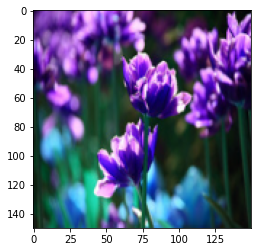

In [14]:
def gen_image(img):
    plt.imshow(img)
    return plt

nb = 500
print(translate_label_from_int_to_str(trainLabel[nb]))
gen_image(trainData[nb]).show()

In [0]:
print(translate_label_from_int_to_str(trainLabel[nb]))
plt.imshow(trainData[500]).show()

## Creating, training and testing a model

## **Model 1**. No data generator. Accuracy: **76%**

In [0]:
#==# stopping the model from overfitting
class training_ceiling(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

In [0]:
epochs=100
batch_size=100

In [0]:
callbacks = training_ceiling()

In [0]:
model = tf.keras.models.Sequential([
                                    
    #===# image processing
    tf.keras.layers.Convolution2D(32, (3,3), activation="relu", input_shape=(img_size,img_size,3)),                       
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    
    #===# creating neural network
    tf.keras.layers.Dense(64, activation= tf.nn.relu),
    tf.keras.layers.Dense(128, activation= tf.nn.relu),
    tf.keras.layers.Dense(64, activation= tf.nn.relu),

    #===# output
    tf.keras.layers.Dense(5, activation=tf.nn.softmax)
])

In [46]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 15, 64)       

In [0]:
model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [48]:
model.fit(
    np.asarray(trainData), 
    np.asarray(trainLabel), 
    validation_data=(np.asarray(testData),np.asarray(testLabel)), 
    epochs=epochs, 
    batch_size=batch_size, 
    callbacks=[callbacks])

Epoch 1/100
70/70 [==============================] - 11s 162ms/step - loss: 1.3582 - accuracy: 0.3914 - val_loss: 1.1645 - val_accuracy: 0.5312
Epoch 2/100
70/70 [==============================] - 11s 152ms/step - loss: 1.0935 - accuracy: 0.5425 - val_loss: 0.9865 - val_accuracy: 0.6006
Epoch 3/100
70/70 [==============================] - 11s 152ms/step - loss: 0.9680 - accuracy: 0.6093 - val_loss: 0.9046 - val_accuracy: 0.6422
Epoch 4/100
70/70 [==============================] - 11s 152ms/step - loss: 0.8980 - accuracy: 0.6478 - val_loss: 0.8498 - val_accuracy: 0.6659
Epoch 5/100
70/70 [==============================] - 11s 151ms/step - loss: 0.8287 - accuracy: 0.6770 - val_loss: 0.8096 - val_accuracy: 0.6734
Epoch 6/100
70/70 [==============================] - 11s 150ms/step - loss: 0.7799 - accuracy: 0.7037 - val_loss: 0.7723 - val_accuracy: 0.6960
Epoch 7/100
70/70 [==============================] - 11s 150ms/step - loss: 0.7272 - accuracy: 0.7251 - val_loss: 0.7441 - val_accuracy:

## Evaluating the model

In [49]:
model.evaluate(np.asarray(testData), np.asarray(testLabel))

55/55 [==============================] - 1s 22ms/step - loss: 1.0570 - accuracy: 0.7618


[1.0569727420806885, 0.7618497014045715]

## **Model 2**. With data generator. Accuracy: **87%**

In [9]:
#==# stopping the model from overfitting
class training_ceiling(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = training_ceiling()

epochs=100
batch_size=128

model = tf.keras.models.Sequential([
                                    
    #===# image processing
    tf.keras.layers.Convolution2D(32, (3,3), activation="relu", input_shape=(img_size,img_size,3)),                       
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    
    #===# creating neural network
    tf.keras.layers.Dense(64, activation= tf.nn.relu),
    tf.keras.layers.Dense(128, activation= tf.nn.relu),
    tf.keras.layers.Dense(64, activation= tf.nn.relu),

    #===# output
    tf.keras.layers.Dense(5, activation=tf.nn.softmax)
])

from keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(
        rotation_range=10,
        zoom_range = 0.1, 
        width_shift_range=0.2,
        height_shift_range=0.2,
        )
data_generator.fit(np.asarray(trainData))

model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(
    data_generator.flow(
        np.asarray(trainData),
        np.asarray(trainLabel), 
        batch_size=batch_size),
    epochs = epochs, 
    validation_data=(np.asarray(testData),
                     np.asarray(testLabel)),
    verbose = 1, 
    steps_per_epoch=np.asarray(trainData).shape[0] // batch_size,
    callbacks=[callbacks])

Using TensorFlow backend.


Epoch 1/100
54/54 [==============================] - 36s 662ms/step - loss: 1.4121 - accuracy: 0.3573 - val_loss: 1.2052 - val_accuracy: 0.5000
Epoch 2/100
54/54 [==============================] - 36s 661ms/step - loss: 1.2158 - accuracy: 0.4754 - val_loss: 1.1069 - val_accuracy: 0.5156
Epoch 3/100
54/54 [==============================] - 35s 650ms/step - loss: 1.1599 - accuracy: 0.5298 - val_loss: 1.0545 - val_accuracy: 0.5699
Epoch 4/100
54/54 [==============================] - 35s 651ms/step - loss: 1.1543 - accuracy: 0.5161 - val_loss: 1.0021 - val_accuracy: 0.6058
Epoch 5/100
54/54 [==============================] - 35s 652ms/step - loss: 0.9774 - accuracy: 0.6055 - val_loss: 0.9392 - val_accuracy: 0.6341
Epoch 6/100
54/54 [==============================] - 35s 656ms/step - loss: 0.9427 - accuracy: 0.6260 - val_loss: 0.9452 - val_accuracy: 0.6376
Epoch 7/100
54/54 [==============================] - 35s 656ms/step - loss: 0.8823 - accuracy: 0.6529 - val_loss: 0.8430 - val_accuracy:

## Evaluate 2

In [10]:
model.evaluate(np.asarray(testData), np.asarray(testLabel))

55/55 [==============================] - 1s 22ms/step - loss: 0.3893 - accuracy: 0.8723


[0.3893045485019684, 0.8722543120384216]

## Mode 3

In [16]:
epochs=100
batch_size=128

model = tf.keras.models.Sequential([
                                    
    #===# image processing
    tf.keras.layers.Convolution2D(32, (3,3), activation="relu", input_shape=(img_size,img_size,3)),                       
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    
    #===# creating neural network
    tf.keras.layers.Dense(64, activation= tf.nn.relu),
    tf.keras.layers.Dense(128, activation= tf.nn.relu),
    tf.keras.layers.Dense(64, activation= tf.nn.relu),

    #===# output
    tf.keras.layers.Dense(5, activation=tf.nn.softmax)
])

data_generator = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True)  # randomly flip images

data_generator.fit(np.asarray(trainData))

model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(
    data_generator.flow(
        np.asarray(trainData),
        np.asarray(trainLabel), 
        batch_size=batch_size),
    epochs = epochs, 
    validation_data=(np.asarray(testData),
                     np.asarray(testLabel)),
    verbose = 1, 
    steps_per_epoch=np.asarray(trainData).shape[0] // batch_size)

Epoch 1/100
27/27 [==============================] - 18s 676ms/step - loss: 1.5524 - accuracy: 0.2705 - val_loss: 1.4503 - val_accuracy: 0.3480
Epoch 2/100
27/27 [==============================] - 18s 671ms/step - loss: 1.5830 - accuracy: 0.2691 - val_loss: 1.5052 - val_accuracy: 0.3202
Epoch 3/100
27/27 [==============================] - 18s 653ms/step - loss: 1.4839 - accuracy: 0.3156 - val_loss: 1.3952 - val_accuracy: 0.3457
Epoch 4/100
27/27 [==============================] - 18s 654ms/step - loss: 1.3367 - accuracy: 0.3958 - val_loss: 1.2323 - val_accuracy: 0.4220
Epoch 5/100
27/27 [==============================] - 18s 652ms/step - loss: 1.2495 - accuracy: 0.4604 - val_loss: 1.2022 - val_accuracy: 0.5202
Epoch 6/100
27/27 [==============================] - 17s 646ms/step - loss: 1.1804 - accuracy: 0.5216 - val_loss: 1.1399 - val_accuracy: 0.5422
Epoch 7/100
27/27 [==============================] - 18s 658ms/step - loss: 1.1437 - accuracy: 0.5204 - val_loss: 1.1052 - val_accuracy:

Evaluate 3

In [17]:
model.evaluate(np.asarray(testData), np.asarray(testLabel))

28/28 [==============================] - 1s 24ms/step - loss: 0.7158 - accuracy: 0.7572


[0.7157760262489319, 0.7572254538536072]